### Question


Compare the classifiers Naive Bayes and Logistic regression using the dataset containing information about housing prices.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression as LogR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine

from sklearn.model_selection import train_test_split as tts,cross_val_score as CVS
from sklearn.metrics import mean_absolute_error,accuracy_score,confusion_matrix,classification_report

## Prepare Data

### Import

In [ ]:
df=pd.read_csv('House_Price.csv')
df.head()

NameError: ignored

In [ ]:
df.shape

In [ ]:
df.dtypes

In [ ]:
# Get the numerical columns in the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of subplots required
num_plots = len(numerical_columns)

# Set up the subplots
fig, axs = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 5))

# Create boxplots for each numerical column
for i, col in enumerate(numerical_columns):
    axs[i].boxplot(df[col])
    axs[i].set_title(col)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We can see there are several variables which have outliers in the data but they are close to the max value of that column. However, We can see that the for n_hot_rooms there are outliers which are very far away from the data. Hence, we define a function called 'wrangle' to remove the unecessary variables and create dummy variable in the place of categorical columns.

In [ ]:
def wrangle(filepath):
    # read csv file
    df=pd.read_csv('House_Price.csv')

    # remove low cardinality
    df.drop(columns=['bus_ter'],inplace=True)

    # remove outliers in n_hot_rooms
    high = df['n_hot_rooms'].quantile(0.9)
    mask_rooms = df['n_hot_rooms'].between(df['n_hot_rooms'].min(), high)

    df=df[mask_rooms]
    # Create dummy variables for 'Class' using pandas' get_dummies() function
    df_dummies = pd.get_dummies(df[['airport','waterbody']], drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df, df_dummies], axis=1)


    # variable transformation
    df['avg_dis']=(df['dist1']+df['dist2']+df['dist3']+df['dist4'])/4
    df.drop(columns=['dist1','dist2','dist3','dist4','airport','waterbody'],inplace=True)

    return df

In [ ]:
df=wrangle('House_Price.csv')
df.head()

Here we can see that we have created dummy variables for airport and waterbody variables and i have took the average distance of the dist 1, dist 2, dist 3 and dist 4 variables to eliminate the problem of highly collinear variables.

In [ ]:
print(df.shape)
df.info()

### Explore

In [ ]:
# missing values
df.isnull().sum()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.select_dtypes('object').nunique()

In [ ]:
df.describe().round(2)

In [ ]:
# Get the numerical columns in the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of subplots required
num_plots = len(numerical_columns)

# Set up the subplots
fig, axs = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 5))

# Create boxplots for each numerical column
for i, col in enumerate(numerical_columns):
    axs[i].boxplot(df[col])
    axs[i].set_title(col)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We can still see that there are several outlier to the data. This might be because of the magnitude of the different variables in the model. So we fit a Standard Scaler to the data and try to reduce the magnitude of the data.

In [ ]:
plt.figure(figsize=(15,15))
corr = df.select_dtypes('number').drop(columns='Sold').corr()
sns.heatmap(corr,annot=True,cmap='Blues')

We can see that there are several variables which are still correlated with each other.

In [ ]:
df_x=df.loc[:,df.columns!='Sold']

In [ ]:
scaler=StandardScaler()
scaler.fit(df_x)

In [ ]:
scaled_data=scaler.transform(df_x)

### Split Data

In [ ]:
X=scaled_data
y=df['Sold']
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)


## Build Model

### Feature Extraction using Decision Tree Classifier

There are numerous ways to choose the features. One of the methods i adopted is to fit a decision tree classifier and then get the feature importances in the data and use them as my main features.

In [ ]:
for i in range(1,10):
  tree=DTC(max_depth=i).fit(X_train,y_train)
  print("Training accuracy of Decision Tree Classifier with max_depth={}: {:.2f}".format(
          i, tree.score(X_train, y_train)))
  print("Test accuracy of Decision Tree Classifier with max_depth={}: {:.2f}".format(
          i, tree.score(X_test, y_test)),"\n")

Training accuracy of Decision Tree Classifier with max_depth=1: 0.58
Test accuracy of Decision Tree Classifier with max_depth=1: 0.45 

Training accuracy of Decision Tree Classifier with max_depth=2: 0.61
Test accuracy of Decision Tree Classifier with max_depth=2: 0.62 

Training accuracy of Decision Tree Classifier with max_depth=3: 0.67
Test accuracy of Decision Tree Classifier with max_depth=3: 0.59 

Training accuracy of Decision Tree Classifier with max_depth=4: 0.72
Test accuracy of Decision Tree Classifier with max_depth=4: 0.61 

Training accuracy of Decision Tree Classifier with max_depth=5: 0.74
Test accuracy of Decision Tree Classifier with max_depth=5: 0.61 

Training accuracy of Decision Tree Classifier with max_depth=6: 0.78
Test accuracy of Decision Tree Classifier with max_depth=6: 0.53 

Training accuracy of Decision Tree Classifier with max_depth=7: 0.83
Test accuracy of Decision Tree Classifier with max_depth=7: 0.64 

Training accuracy of Decision Tree Classifier wi

Here we can see that the best Decision Tree model is the one with max_depth=7.
Therefore, we select that model and try to find the best features using this and continue forward with out analysis.

In [ ]:
tree=DTC(max_depth=7).fit(X_train,y_train)

Feature importances:  [0.286 0.017 0.    0.145 0.    0.016 0.152 0.022 0.119 0.021 0.012 0.
 0.    0.012 0.    0.197] 
 Index(['price', 'resid_area', 'air_qual', 'room_num', 'age', 'teachers',
       'poor_prop', 'n_hos_beds', 'n_hot_rooms', 'rainfall', 'parks',
       'airport_YES', 'waterbody_Lake and River', 'waterbody_None',
       'waterbody_River', 'avg_dis'],
      dtype='object')


<Axes: >

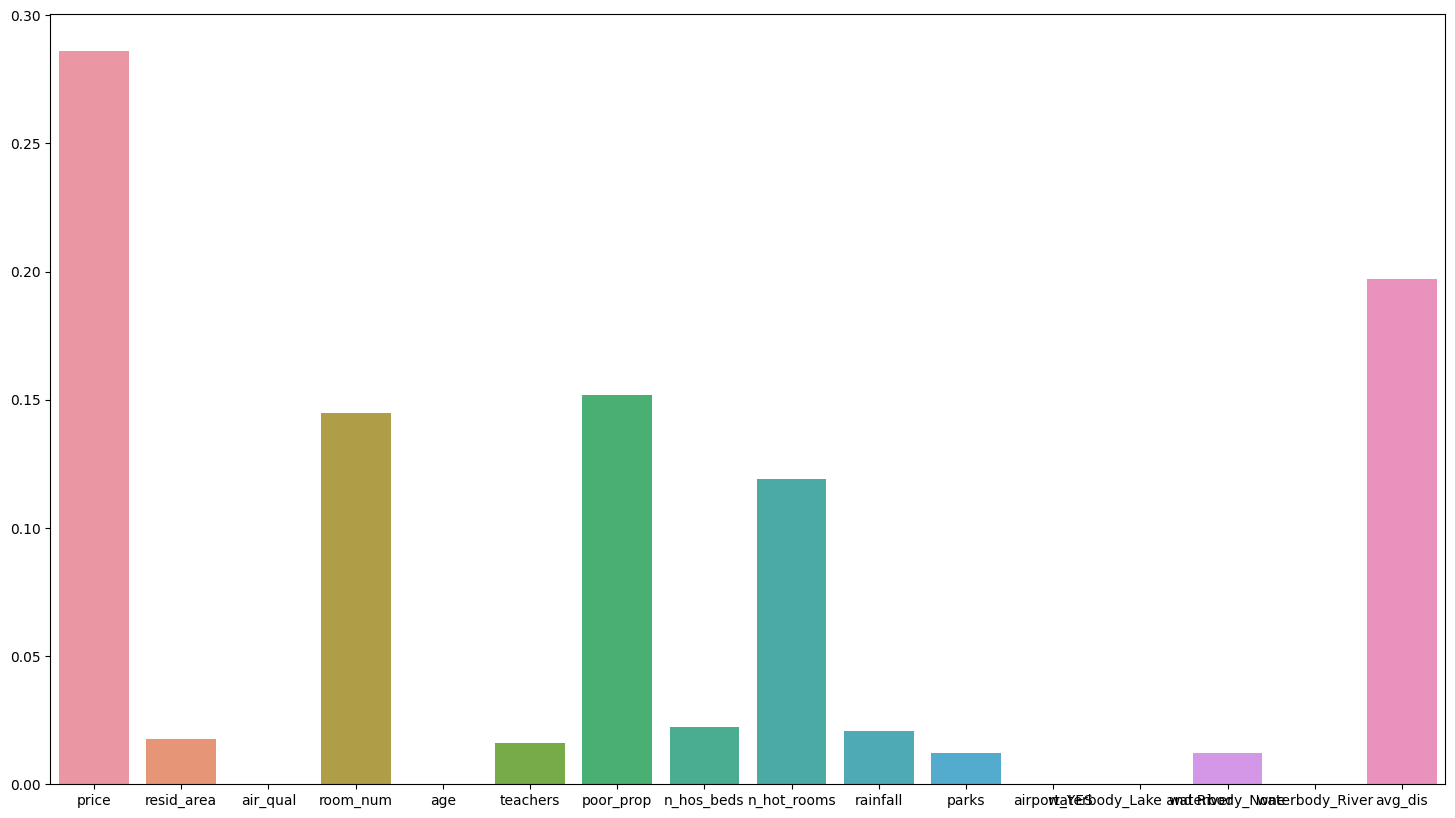

In [ ]:
print("Feature importances: ",tree.feature_importances_.round(3),"\n",df_x.columns)
plt.figure(figsize=(18,10))
sns.barplot(x=df_x.columns,y=tree.feature_importances_)

Here we can see that the best features with most feature importances.
Hence, we select them as out features in our model and continue with our analysis.

In [ ]:
df_x.columns

Index(['price', 'resid_area', 'air_qual', 'room_num', 'age', 'teachers',
       'poor_prop', 'n_hos_beds', 'n_hot_rooms', 'rainfall', 'parks',
       'airport_YES', 'waterbody_Lake and River', 'waterbody_None',
       'waterbody_River', 'avg_dis'],
      dtype='object')

In [ ]:
X=df_x.drop(columns=['air_qual','age','airport_YES','waterbody_Lake and River','waterbody_River'])
X.columns

Index(['price', 'resid_area', 'room_num', 'teachers', 'poor_prop',
       'n_hos_beds', 'n_hot_rooms', 'rainfall', 'parks', 'waterbody_None',
       'avg_dis'],
      dtype='object')

In [ ]:
scaler1=StandardScaler()
scaler1.fit(X)
scaled_data1=scaler1.transform(X)

In [ ]:
xtrain,xtest,ytrain,ytest=tts(scaled_data1,y,test_size=0.3,random_state=0)

In [ ]:
gnb=GNB().fit(xtrain,ytrain)

In [ ]:
y_pred_gnb=gnb.predict(xtest)
print("Accuracy on training set: {:.3f}".format(gnb.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(gnb.score(xtest, ytest)))
print("The Confusion Matrix is \n",confusion_matrix(ytest,y_pred_gnb))
print(classification_report(ytest,y_pred_gnb))

Accuracy on training set: 0.628
Accuracy on test set: 0.570
The Confusion Matrix is 
 [[30 31]
 [27 47]]
              precision    recall  f1-score   support

           0       0.53      0.49      0.51        61
           1       0.60      0.64      0.62        74

    accuracy                           0.57       135
   macro avg       0.56      0.56      0.56       135
weighted avg       0.57      0.57      0.57       135



For the Naive Bayes model for this specific dataset after all the hyper parameter tuning we can see that the accuracy of the model is 62.8% on the training data and 57% on the testing data. Which is not a good fit. We try to fit a Logistic Regression model and check for the accuracy measures.

In [ ]:
log_model=LogR().fit(xtrain,ytrain)

In [ ]:
y_pred_lr=log_model.predict(xtest)
print("Accuracy on training set: {:.3f}".format(log_model.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(log_model.score(xtest, ytest)))
print("The Confusion Matrix is \n",confusion_matrix(ytest,y_pred_lr))
print(classification_report(ytest,y_pred_lr))

Accuracy on training set: 0.699
Accuracy on test set: 0.644
The Confusion Matrix is 
 [[46 15]
 [33 41]]
              precision    recall  f1-score   support

           0       0.58      0.75      0.66        61
           1       0.73      0.55      0.63        74

    accuracy                           0.64       135
   macro avg       0.66      0.65      0.64       135
weighted avg       0.66      0.64      0.64       135



We can see that the Logistic model is performing better than the Naive Bayes model for this particular dataset. The accuracy of the training set is ~70% and testing set is 64%.

### Question


Wine quality dataset contains various physicochemical properties of different wines, along with their quality ratings. Explore the classification performance with the optimal number of principal components to retain based on explained variance ratio.

#### Prepare Data

In [ ]:
data=load_wine()

In [ ]:
print(data.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

We can see this data has three classes in its dependent variable. There are 13 features in the data, we try to reduce the features without any reduction in accuracy.

In [ ]:
dfq6=pd.DataFrame(data['data'],columns=data['feature_names'])

In [ ]:
dfq6.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


We can see the variation in the data/ magnitude of the features is very different. Hence, we fit a standard scaler with mean 0 and standard deviation 1.

<Axes: >

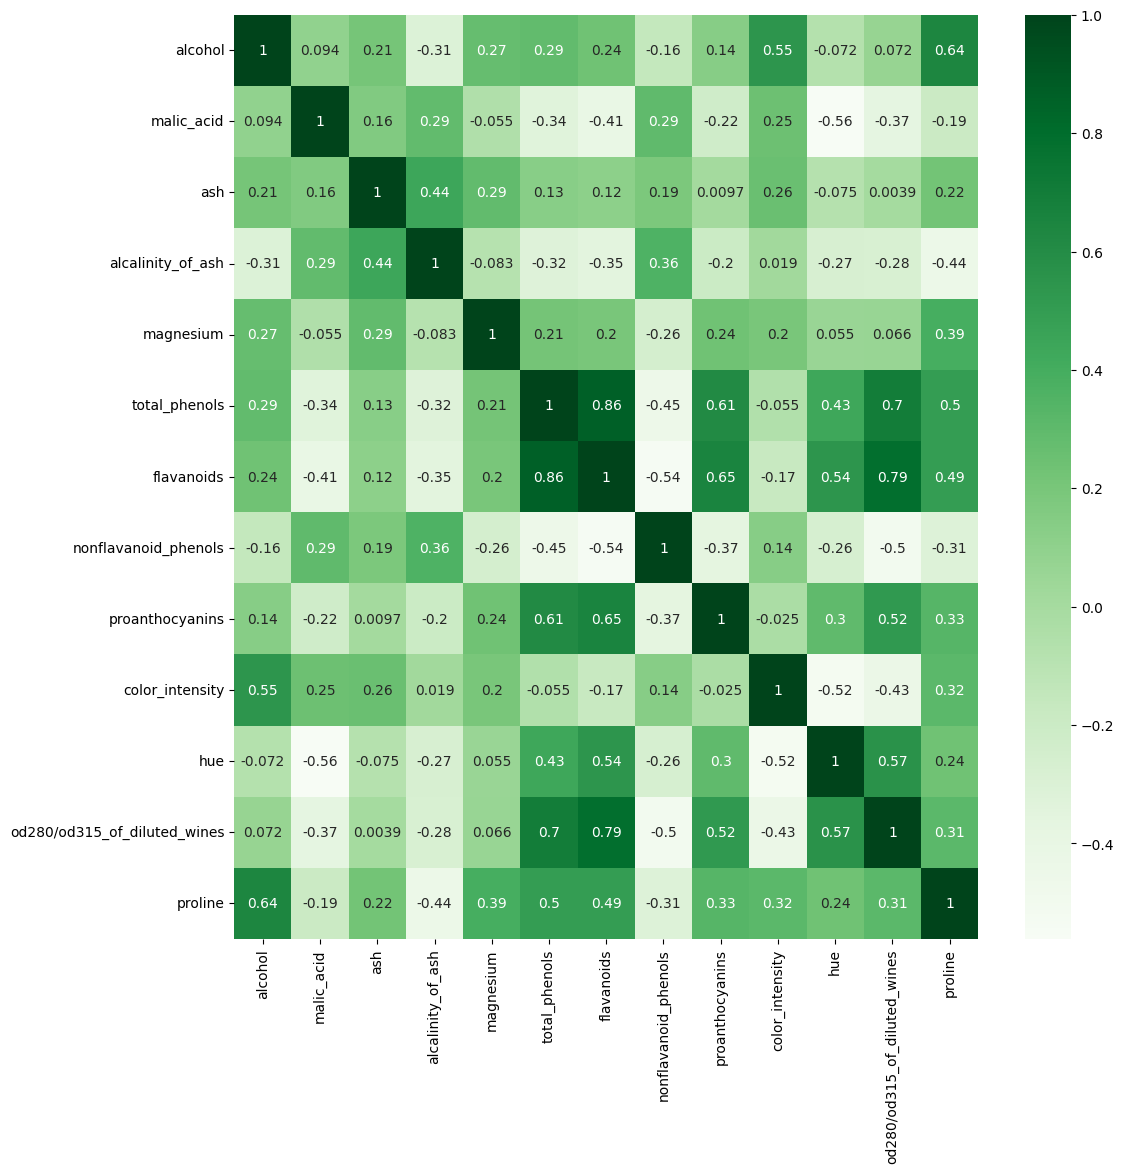

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(dfq6.corr(),annot=True,cmap='Greens')

Here mostly all the variables are not so correlated in the dataset. However, there are a few variables for ex: proline and alcohol are 64% correlated and there are couple of variables which might cause a problem. We try to eliminate that by fitting a standard scaler.

In [ ]:
scalerq6=StandardScaler().fit(dfq6)
scaled_dataq6=scalerq6.transform(dfq6)

In [ ]:
scaled_dataq6.shape

(178, 13)

#### Modelling

In [ ]:
pca=PCA().fit(scaled_dataq6)

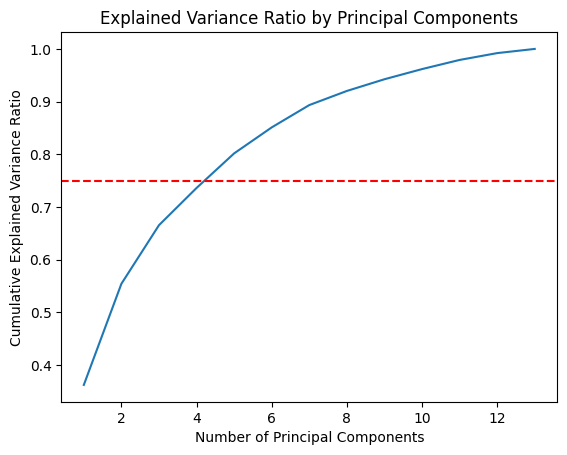

In [ ]:
# Calculate the explained variance ratio for each PC
explained_var_ratio = pca.explained_variance_ratio_

# Plot the cumulative explained variance ratio
cumulative_var_ratio = np.cumsum(explained_var_ratio)
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio)
# Add a horizontal line at the cutoff value(75%)
cutoff_ratio = 0.75
plt.axhline(y=cutoff_ratio, color='r', linestyle='--', label=f'Cutoff: {cutoff_ratio}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.show()

Here i have set the threshold limit at 75% explained variance. I selected 75% randomly. We need a high explained variance to fit the data better and improve the accuracy and reduce the computing time. Here, the threshold limit is passed at 4 components. Hence, we fit PCA to reduce the dimension to 4 from 13.

In [ ]:
pca=PCA(n_components=4).fit(scaled_dataq6)

In [ ]:
# Fitting the model to the original data
Xq6=scaled_dataq6
yq6=data.target
x1_train,x1_test,y1_train,y1_test=tts(Xq6,yq6,test_size=0.3,random_state=0)

In [ ]:
# Fitting a Naive Bayes Model
gnb_npca=GNB().fit(x1_train,y1_train)

In [ ]:
y1_pred_gnb=gnb_npca.predict(x1_test)
print("Accuracy on training set: {:.3f}".format(gnb_npca.score(x1_train, y1_train)))
print("Accuracy on test set: {:.3f}".format(gnb_npca.score(x1_test, y1_test)))
print("The Confusion Matrix is \n",confusion_matrix(y1_test,y1_pred_gnb))
print(classification_report(y1_test,y1_pred_gnb))

Accuracy on training set: 0.984
Accuracy on test set: 0.944
The Confusion Matrix is 
 [[19  0  0]
 [ 2 19  1]
 [ 0  0 13]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.86      0.93        22
           2       0.93      1.00      0.96        13

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.95        54
weighted avg       0.95      0.94      0.94        54



From the results above we can see that the training accuracy for the model with standard scaler is 98% and testing accuracy is around 94%. From the confusion matrix we can see that only 3 of the variables are misclassified.

In [ ]:
# Fitting a Naive Bayes Model to Dimension Reduced Data
pcax=pca.transform(scaled_dataq6)
xpca_train,xpca_test,ypca_train,ypca_test=tts(pcax,y,test_size=0.3,random_state=0)

In [ ]:
gnb_pca=GNB().fit(xpca_train,ypca_train)

In [ ]:
ypca_pred_gnb=gnb_pca.predict(xpca_test)
print("Accuracy on training set: {:.3f}".format(gnb_pca.score(xpca_train, ypca_train)))
print("Accuracy on test set: {:.3f}".format(gnb_pca.score(xpca_test, ypca_test)))
print("The Confusion Matrix is \n",confusion_matrix(ypca_test,ypca_pred_gnb))
print(classification_report(ypca_test,ypca_pred_gnb))

Accuracy on training set: 0.952
Accuracy on test set: 1.000
The Confusion Matrix is 
 [[19  0  0]
 [ 0 22  0]
 [ 0  0 13]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        13

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



After fitting the naive bayes model for the standard scaler fitted and dimension reduced data we can see that the training accuracy has decreased a bit but however, the testing accuracy is 100%. This might be due to the size of the dataset which only consists of 178 observations.

#### Cross Validation

In [ ]:
# Create an instance of the Naive Bayes classifier
naive_bayes = GNB()

# Perform cross-validation
cross_val_scores = CVS(naive_bayes, xpca_train, ypca_train, cv=10)

# Print the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Average Accuracy:", cross_val_scores.mean())

# Train the Naive Bayes classifier on the training set
naive_bayes.fit(xpca_train, ypca_train)

# Evaluate the model on the training set and testing set
accuracy = naive_bayes.score(xpca_test, ypca_test)
print("Test Accuracy:", accuracy)

Cross-Validation Scores: [0.84615385 0.92307692 0.92307692 0.92307692 1.         1.
 0.91666667 1.         0.91666667 1.        ]
Average Accuracy: 0.9448717948717948
Test Accuracy: 1.0


After applying 10 fold cross validation the testing accuracy of the model has not changed and we can conclude that reducing the dimensions for a small dataset might cause overfitting and reduces the predictability of the model.
